In [1]:
import numpy as np
import librosa
from scipy import signal
import IPython.display as ipd
from scipy.signal import find_peaks

import Plot
import Constants
from Constants import OSE_SAMPLE_RATE, FFT_HOP
import Functions
from Ellis_07_Search import ellis_07_search

MOMENTUM = 0.01
FOD = None
ITERATIONS = 1

# Placeholder for current file and its sample rate
CURRENT_SIGNAL = None
SR = None


def calculate_onset_strength_envelope(audio, sr):
    """
    Takes an audio signal and its sample rate and converts it to the onset strength envelope as described in Ellis-07
    """
    # Resample to 8kHz
    audio = librosa.core.resample(audio, sr, OSE_SAMPLE_RATE)

    # Calculate STFT with 32ms windows (256 samples given 8kHz sr) and 4ms hop
    spectrogram = np.abs(librosa.core.stft(audio, n_fft=512, hop_length=FFT_HOP)) ** 2

    # Map to 40 Mel bands
    mel_spectrogram = librosa.feature.melspectrogram(audio, OSE_SAMPLE_RATE, spectrogram, n_mels=40)

    # Calculate first order difference over time axis
    FOD = np.diff(mel_spectrogram, n=1, axis=1)
    # Perform half-wave rectification
    FOD[FOD < 0] = 0

    # Sum remaining values over frequency-band axis
    FOD = np.sum(FOD, axis=0)

    # High-pass resulting signal with cutoff at 0.4Hz
    ose = Functions.apply_highpass_filter(FOD, OSE_SAMPLE_RATE, 0.4, 2)

    # Convolve with 20ms Gaussian window
    M = 0.02 * OSE_SAMPLE_RATE
    std = np.ceil(M / 12)
    window = signal.gaussian(M, std, sym=True)
    ose = signal.convolve(ose, window, mode='same') / sum(window)

    # Normalise by dividing by standard deviation
    ose = ose / np.std(ose)

    return ose


def state_space_search(ose, tau_index, is_duple_tempo):
    """
    State-space search approach to beat tracking: This function goes through the onset strength envelope
    and finds suitable candidates for beats.
    :param ose: The onset strength envelope from Ellis-07
    :param tau_index: Initial estimation of distance to next beat
    :param is_duple_tempo: Whether duple (True) or triple (False) tempo is assumed
    :return: The indices of beats and downbeats
    """
    # Found beats are store here
    beats = []
    # Counter to keep track of the "type" of current beat (e.g. 1, 2, 3, or 4 for a 4/4 measure)
    downbeat_counter = 1
    # Metre inferred from estimated tempo function
    # Supported metres are 3/4 and 4/4
    metre = 4 if is_duple_tempo else 3
    beat_numbers = []

    # Find peaks in the onset strength envelope
    peaks = find_peaks(ose)[0]
    # Find first peak
    first_peak = peaks[0]
    # Set the first beat to the first peak in the onset strength envelope
    beats.append(first_peak)
    # Set beat number
    beat_numbers.append(downbeat_counter)
    # Variable to keep track of the current position in the onset strength envelope
    index = first_peak
    while index + tau_index < ose.size:
        # Look for next peak in the range of (index + tau_index) +/- window
        window = 24  # 96ms
        # The exact position of the next expected beat, according to the current tempo estimate
        expected = index + tau_index
        # The search space around the expected beat
        space = np.arange(expected - window, expected + window)
        # Flag indicating whether a peak was found in the current search space
        found = False
        # Go through the search space and look for a peak
        for candidate in space:
            if candidate in peaks:
                found = True
                # Get difference of expectation
                diff = expected - candidate
                # Adjust assumed tempo
                if diff != 0:
                    tau_index = int((tau_index * 2 - diff) / 2)
                # Update current position in the onset strength envelope
                index = candidate
                # Add found beat to list of beats
                beats.append(candidate)

                # Estimate beat strength
                # Reset downbeat counter if it is over the metre value
                if downbeat_counter > metre:
                    downbeat_counter = 1
                # Append current beat number to beat numbers array
                beat_numbers.append(downbeat_counter)
                downbeat_counter = downbeat_counter + 1
                break
        # If no suitable candidate for a beat was found in the given search space
        # Start looking for the next peak starting from the current position + a given window size
        # The size of the window is increased until the next peak is found
        if found is False:
            # Assume that there is a longer break
            # Look for next peak and start again from there
            candidate = None
            # Multiplicator for the window: This increases in order to extend the search window
            # if no suitable candidate has been found yet
            look_ahead = 1
            while candidate is None and index + window * look_ahead <= ose.size:
                ext_window = window * look_ahead
                cur_peaks = find_peaks(ose[index + tau_index:index + tau_index + ext_window])[0]
                look_ahead = look_ahead + 1
                # If a peak was found, choose it for the next beat candidate
                if len(cur_peaks) > 0:
                    candidate = index + cur_peaks[0]
                    index = candidate
                    break
            if candidate is None:
                # Reached the end of the onset strength envelope
                # Collect indices of downbeats and return results
                downbeat_indices = [i for i, x in enumerate(beat_numbers) if x == 1]
                # Convert to onset strength envelope indices
                downbeats = [beats[i] for i in downbeat_indices]
                return beats, downbeats
            else:
                # If a candidate was found through the extended search append it and continue
                beats.append(candidate)
                # The extended search usually happens when there is a longer break in the piece
                # Therefore the downbeat counter is reset to 1 after break, assuming that the found beat
                # will be a downbeat
                downbeat_counter = 1
                beat_numbers.append(downbeat_counter)
                downbeat_counter = downbeat_counter + 1

    # Get indices of downbeats
    downbeat_indices = [i for i, x in enumerate(beat_numbers) if x == 1]
    # Convert to frame indices
    downbeats = [beats[i] for i in downbeat_indices]
    return beats, downbeats

def run(file):
    global ITERATIONS
    global CURRENT_SIGNAL, SR

    Constants.TAU_0 = Functions.find_tempo_period_bias()
    CURRENT_SIGNAL, SR = librosa.core.load(file)

    ose = calculate_onset_strength_envelope(CURRENT_SIGNAL, SR)
    tau_est, tau_index, is_duple_tempo = Functions.estimate_tempo(ose)

    beats, downbeats = state_space_search(ose, tau_index, is_duple_tempo)
    return beats, downbeats, ose, CURRENT_SIGNAL

def analyse(file):
    beats, downbeats, ose, y = run(file)
    return beats, downbeats, ose

C:\Users\Max\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\Max\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


TP accuracy for Albums-Cafe_Paradiso-06.wav: 0.89
TP downbeat accuracy: 0.71
F-measure: 0.77
F-measure for downbeats: 0.56


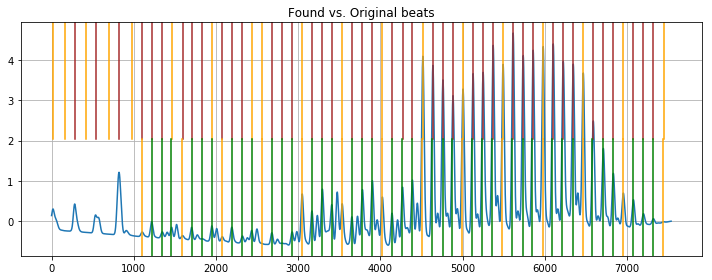

In [3]:
import Evaluation
current_file = "BallroomData\\ChaChaCha\\Albums-Cafe_Paradiso-06.wav"
#current_file = "BallroomData\\Rumba-Misc\\Media-103511.wav"
#current_file = "BallroomData\\ChaChaCha\\Albums-Fire-14.wav"

current_sig, sr = librosa.load(current_file)

correct, found, correct_downbeats, found_downbeats, ose, accuracy, accuracy_down, f_measure, f_measure_d = Evaluation.evaluate_file(current_file)
Plot.plot_evaluation(correct, found, correct_downbeats, found_downbeats, ose)

# Create click for each beat
clicks = librosa.clicks(times=np.array(found) * FFT_HOP / OSE_SAMPLE_RATE, sr=OSE_SAMPLE_RATE)
clicks = librosa.core.resample(clicks, OSE_SAMPLE_RATE, 22050)

minsize = np.min([clicks.size, current_sig.size])
result = current_sig[:minsize] + clicks[:minsize]

ipd.Audio(result, rate=22050)